In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.utils as dsutils 
import deepgeo.common.geofunctions as gf
import deepgeo.networks.model_builder as mb

reload(dtaug)
reload(dsutils)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.common.geofunctions' from '../src/deepgeo/common/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../', 'data_real', 'generated')
network = 'unet'
DATA_DIR = '/home/raian/doutorado/Dados/generated'
DATASET_FILE = os.path.join(DATA_DIR, 'new_dataset_286x286_timesstack-2013-2017.npz')

# model_dir = os.path.join(DATA_DIR, 'tf_logs', network,
#                          'test_%s_%s' % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
model_dir = '/home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug'
# model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet', 'test_unet_29_04_2019-12_51_06')
train_tfrecord = os.path.join(DATA_DIR, 'train.tfrecord')
test_tfrecord = os.path.join(DATA_DIR, 'test.tfrecord')
val_tfrecord = os.path.join(DATA_DIR, 'validation.tfrecord')

In [3]:
!rm -rf {model_dir}/*
!ls -al {model_dir}

total 8
drwxr-xr-x 2 raian digits 4096 May 17 20:03 .
drwxr-xr-x 3 raian digits 4096 Dec  7 19:52 ..


# Split dataset between train, test and validation data

In [4]:
dataset = np.load(DATASET_FILE)

print("Data Loaded:")
print("  -> Images: ", len(dataset["images"]))
print("  -> Labels: ", len(dataset["labels"]))
print("  -> Classes: ", len(dataset["classes"]))

print("Images shape: ", dataset["images"][0].shape, " - DType: ", dataset["images"][0].dtype)
print("Labels shape: ", dataset["labels"][0].shape, " - DType: ", dataset["labels"][0].dtype)
print('Classes: ', dataset['classes'])
# print("UNIQUE LABELS: ", np.unique(dataset["labels"]))

Data Loaded:
  -> Images:  7872
  -> Labels:  7872
  -> Classes:  3
Images shape:  (286, 286, 10)  - DType:  float32
Labels shape:  (286, 286, 1)  - DType:  int32
Classes:  ['no_data' 'not_deforestation' 'deforestation']


In [5]:
train_images, test_images, valid_images, train_labels, test_labels, valid_labels = dsutils.split_dataset(dataset,
                                                                                                         perc_test=20,
                                                                                                         perc_val=20)

print("Splitted dataset:")
print("  -> Train images: ", train_images.shape)
print("  -> Test images: ", test_images.shape)
print("  -> Validation images: ", valid_images.shape)
print("  -> Train Labels: ", train_labels.shape)
print("  -> Test Labels: ", test_labels.shape)
print("  -> Validation Labels: ", valid_labels.shape)
total_train_chips = train_images.shape[0]

Splitted dataset:
  -> Train images:  (4723, 286, 286, 10)
  -> Test images:  (1574, 286, 286, 10)
  -> Validation images:  (1575, 286, 286, 10)
  -> Train Labels:  (4723, 286, 286, 1)
  -> Test Labels:  (1574, 286, 286, 1)
  -> Validation Labels:  (1575, 286, 286, 1)


# Perform Data Augmentation

In [6]:
# angles = [90, 180, 270]
# rotated_imgs = dtaug.rotate_images(train_images, angles)
# flipped_imgs = dtaug.flip_images(train_images)

# train_images = np.concatenate((train_images, rotated_imgs, flipped_imgs))
# # train_images = np.concatenate((train_images, ))

# rotated_lbls = dtaug.rotate_images(train_labels, angles)
# flipped_lbls = dtaug.flip_images(train_labels)

# train_labels = np.concatenate((train_labels, rotated_lbls, flipped_lbls))
# # train_labels = np.concatenate((train_labels, )).astype(dtype=np.int32)

# print('Data Augmentation Applied:')
# print('  -> Train Images: ', train_images.shape)
# print('  -> Train Labels: ', train_labels.shape)

## Save to TFRecords

In [7]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [8]:
# def wrap_bytes(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def wrap_float(value):
#     return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

# def wrap_int64(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# def save_to_tfrecord(out_path, imgs, labels):
#     with tf.python_io.TFRecordWriter(out_path) as writer:
# #         total_prog = imgs.shape[0]
#         for i in range(imgs.shape[0]):
# #             print_progress(i, total_prog)
#             img = imgs[i, :, :, :]
#             lbl = labels[i, :, :, :]
            
#             height = img.shape[0]
#             width = img.shape[1]
#             channels = img.shape[2]
            
#             img_raw = img.tostring()
#             lbl_raw = lbl.tostring()
            
#             feature = {'image': wrap_bytes(img_raw),
#                        'label': wrap_bytes(lbl_raw),
#                        'channels': wrap_int64(channels),
#                        'height': wrap_int64(height),
#                        'width': wrap_int64(width)}
            
#             example = tf.train.Example(features=tf.train.Features(feature=feature))
#             writer.write(example.SerializeToString())

# save_to_tfrecord(train_tfrecord, train_images, train_labels)
# save_to_tfrecord(test_tfrecord, test_images, test_labels)
# save_to_tfrecord(val_tfrecord, valid_images, valid_labels)

## Computing weights

In [9]:
def compute_weights_mean_proportion(batch_array, classes, classes_zero=['no_data']):
    values, count = np.unique(batch_array, return_counts=True)
    count = [count[i] if classes[i] not in classes_zero else 0 for i in range(0, len(count))]
    total = sum(count)
    proportions = [i / total for i in count]
    mean_prop = sum(proportions)/ (len(proportions) - len(classes_zero))
    weights = [mean_prop / i if i != 0 else 0 for i in proportions]
    return weights


weights_train = compute_weights_mean_proportion(train_labels, dataset['classes'])
weights_eval = compute_weights_mean_proportion(test_labels, dataset['classes'])

## Plot chips to check Data Augmentation

In [10]:
# import random
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# import matplotlib.colors as colors

# def plot_chips_and_labels(imgs, lbls, pos):
#     plt.figure(figsize=(30,30))
#     plt.subplots(nrows=10, ncols=10)
#     count = 1
#     plt.subplot(1, 2, count)
#     plt.title(str(pos))
#     plt.axis('off')
#     count += 1
#     plt.imshow(imgs[pos][:,:,[8, 7, 6]], interpolation='nearest')

#     colorMap = ListedColormap(['white', 'green', 'red'])
#     plt.subplot(1, 2, count)
#     #     plt.title('pos %d' % (pos))
#     plt.title(str(np.unique(lbls[pos])))
#     plt.axis('off')
#     count += 1
#     plt.imshow(lbls[pos][:,:,0], interpolation='nearest', cmap=colorMap)


# pos = random.randrange(0, total_train_chips)
# pos_1 = pos

# plot_chips_and_labels(train_images, train_labels, pos)
# pos += total_train_chips
# plot_chips_and_labels(train_images, train_labels, pos)
# pos += total_train_chips
# plot_chips_and_labels(train_images, train_labels, pos)
# pos += total_train_chips
# plot_chips_and_labels(train_images, train_labels, pos)
# pos += ((total_train_chips - pos_1) + (3 * pos_1))
# plot_chips_and_labels(train_images, train_labels, pos)
# pos += 1
# plot_chips_and_labels(train_images, train_labels, pos)
# pos += 1
# plot_chips_and_labels(train_images, train_labels, pos)

# Train the Network

In [11]:
params = {
    'epochs': 1,
    'batch_size': 40,
    'filter_reduction': 0.5,
    'learning_rate': 0.1,
    'learning_rate_decay': True,
    'decay_rate': 0.95,
    # 'decay_steps': 1286,
    'l2_reg_rate': 0.0005,
    # 'var_scale_factor': 2.0,  # TODO: Put the initializer as parameter
    'chips_tensorboard': 2,
    # 'dropout_rate': 0.5,  # TODO: Put a bool parameter to apply or not Dropout
    'fusion': 'early',
    'loss_func': 'weighted_crossentropy',
    'data_aug_ops': ['rot90', 'rot180', 'rot270', 'flip_left_right',
                     'flip_up_down', 'flip_transpose'],
    'class_weights': {'train': weights_train, 'eval': weights_eval},
    'num_classes': len(dataset['classes']),
    'class_names': ['no data', 'not deforestation', 'deforestation'],
    'num_compositions': 2,
    'bands_plot': [[1, 2, 3], [6, 7, 8]],
    'Notes': 'Testing.'
}
reload(mb)
model = mb.ModelBuilder(network)

In [12]:
# model.train(train_images, test_images, train_labels, test_labels, params, model_dir)
model.train(train_tfrecord, test_tfrecord, params, model_dir)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TOTAL CHIPS:  4723

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_device_

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 206: /home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug/model.ckpt-206
INFO:tensorflow:Finalize strategy.
INFO:tensorflow:Loss for final step: 0.45359498.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug/model.ckpt-206
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<<------------------------------------------------------------>>
<<------------------ Validation Results ---------------------->>
<<------------------------------------------------------------>>
F1-Score:
  - not deforestation: 0.8697282105397091
  - deforestation: 0.0
Precision:
  - no data: 0.0
  - not deforestation: 0.7695148776077728
  - deforestation: 0.0
Recall:
  - no data: 0.0
  - not deforestation: 0.999951072591113
  - deforestation: 0.0
ROC: 
  - FPR: [ 0.0 3.781840964467659e-05 1.0 ]
  - TPR: [ 0.0 0.0 1.0 ]
  - Thresholds: [ 3 2 1 ]
AUC-ROC: 0.49998109079517766
Classification Report:
                   precision    recall  f1-score   support

          no data       0.00      0.00      0.00   3560198
not deforestation       0.77      1.00      0.87  12119996
    deforestation       0.00      0.00      0.00     69806

      avg / total       0.59      0.77      0.67  15750000

Confusion Matrix:
[[9.99951073e-01 4.89274089e-05]
 [1.00000000e+00 0.00000000e+00]]



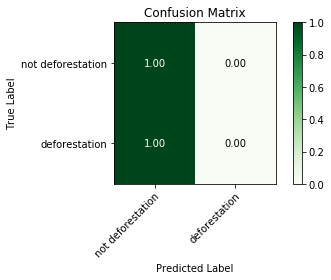

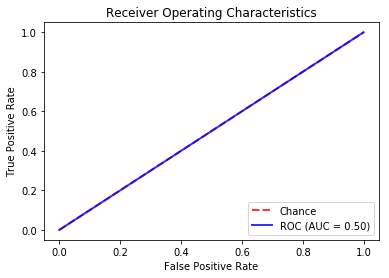

In [13]:
model.validate(valid_images, valid_labels, params, model_dir)